# Leverage score approximation using Divide And Conquer (DAC) algorithm.


We present here an example of Nyström approximation for a random data matrix, using an RBF kernel.

In [74]:
import numpy as np
from sklearn.metrics.pairwise import *
import sys
from scipy.linalg import svd
from math import *
import os
import scipy.linalg as spl
import matplotlib.pyplot as plt


In [73]:
def DAC(X, lambda_, sample_size, kernel_function, kernel_param):
  """
  This function computes an approximation of the ridge leverage score, using a divide and conquer strategy.
  X: numpy array of size (n, d) where n is the number of data and d number of features.
  lambda_: regularisation term.
  sample_size: size of sub-matrix.
  kernel_function: a function that compute the kernel matrix, in the same form as the functions of the sklearn.metrics.pairwise library.
  kernel_param: the parameter of the kernel function (the degree if polynomial kernel for example).
  """

  if (lambda_ < 0 or kernel_param < 0):
    print("lambda_ and kernel_param have to be positive")
    exit(1)

  n = X.shape[0]
  ind = np.arange(n)
  approximated_ls = np.zeros((n))
  np.random.shuffle(ind)


  for l in range(0, ceil(n/sample_size)):
    true_sample_size = min(sample_size, n - l*sample_size)
    temp_ind = ind[l*sample_size: l*sample_size + true_sample_size]
    K_S = kernel_function(X[temp_ind], X[temp_ind], kernel_param)
    a = np.sum(K_S * np.linalg.inv(K_S + lambda_ * np.eye(true_sample_size)) , axis = 1)
    approximated_ls[temp_ind] = a

  return approximated_ls



In [75]:

def nystrom_approximation_fit(X, S, kernel_function, kernel_param):
  """
  This function approximates the kernel matrix K_{i, j} = k(x_i, x_j), using only the data indexed by S

  X: numpy array of size (n, d) where n is the number of data and d number of features.
  S: list of selected data indices for the Nystrom approximation.
  kernel_function: a function that compute the kernel matrix, in the same form as the functions of the library sklearn.metrics.pairwise.
  kernel_param: the parameter of the kernel function (the degree if polynomial kernel for example).


  Sortie:
  mapped_X: numpy array of size (n, |S|)
  inv_K_s: numpy array of size (|S|, |S|)
  """

  K_1_1 = kernel_function(X[S], X[S], kernel_param)

  # sqrt of kernel matrix on basis vectors
  U, sigma, V = svd(K_1_1)
  sigma = np.maximum(sigma, 1e-12)

  # compute K_{1, 1}^{-1/2}
  normalization_ = np.dot(U / np.sqrt(sigma), V) 

  embedded = kernel_function(X, X[S], kernel_param)

  X_mapped = np.dot(embedded, normalization_.T)
  return X_mapped, normalization_
	
	


In [76]:
#generate random matrix and compute the kernel matrix
n, d = 500, 2
X = np.random.normal(size=(n, d))

#compute approximated leverage scores using DAC algorithm
kernel_parameter = 1
lambda_ = 1

#the size of each sub-matrix is equal to \sqrt{n}. 
sample_size = int(log(n))
approximated_leverage_scores = DAC(X, lambda_, sample_size, rbf_kernel, kernel_parameter)

#sample 10% of data proportionally to these scores
selected = np.random.choice(n, size=int(0.1*n), replace=False, p=approximated_leverage_scores/np.sum(approximated_leverage_scores))

#compute Nyström approximation suing the sampled data
X_mapped, inv_K_s = nystrom_approximation_fit(X, selected, rbf_kernel, kernel_parameter)
approximated_K = np.dot(X_mapped, X_mapped.T)
K = rbf_kernel(X, X, kernel_parameter)
print("The spectral error is: ", np.linalg.norm(approximated_K - K, 'fro'))


The spectral error is:  7.015826203771906


We can see how the spectral error behaves according to the number of data used in the Nyström method.

In [77]:
pr_nystrom_data = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
spectral_error = np.zeros(len(pr_nystrom_data))
nb_repeat = 10

for _ in range(nb_repeat):
  for (i, pr) in zip(range(len(pr_nystrom_data)), pr_nystrom_data):
    #sample pr% of data proportionally to these scores
    selected = np.random.choice(n, size=int(pr*n), replace=False, p=approximated_leverage_scores/np.sum(approximated_leverage_scores))

    #compute Nyström approximation suing the sampled data
    X_mapped, inv_K_s = nystrom_approximation_fit(X, selected, rbf_kernel, kernel_parameter)
    approximated_K = np.dot(X_mapped, X_mapped.T)
    spectral_error[i] = np.linalg.norm(approximated_K - K, 'fro')

spectral_error /= nb_repeat

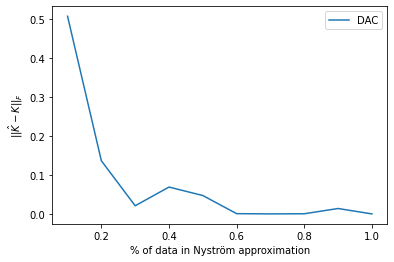

In [78]:
# plot the error:
plt.plot(pr_nystrom_data, spectral_error, label = 'DAC')
plt.xlabel('% of data in Nyström approximation')
plt.ylabel(r'$|| \hat{K} - K||_F$')
plt.legend()
plt.show()